In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as datetime

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Inspect the station details / columns
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
        print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Inspect the measurement details / columns
columns = inspector.get_columns('measurement')
for c in columns:
        print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [13]:
# Find the last date

max_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(10).all()
max_date[0][0]

'2017-08-23'

In [14]:
# Find the last date

min_date = session.query(func.min(func.strftime("%Y-%m-%d", Measurement.date))).limit(10).all()
min_date[0][0]

'2010-01-01'

##### Please note that the database runs from January 1, 2010 to August 23, 2017

#### Precipitation Analysis

In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

# In our database we will search from 2016-08-23 to 2017-08-23

precipitation_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= datetime.date(2016, 8, 23)).all()

#precipitation_data


In [46]:
# Create DataFrame and Show Results
precipitation_v2_data = pd.DataFrame(precipitation_data, columns = ['date', 'precipitation'])

precipitation_v2_data.set_index('date', inplace=True)

precipitation_v2_data


,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [47]:
# Sort the dataframe
precipitation_v2_data = precipitation_v2_data.sort_values(by='date')
precipitation_v2_data

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


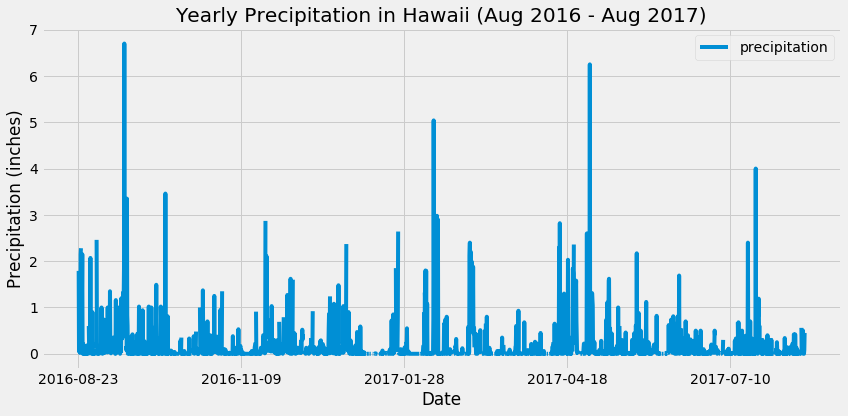

In [51]:
# Plot the results
fig, ax=plt.subplots(figsize = (12,6))

precipitation_v2_data.plot(ax=ax, x_compat = True)

# Title & Lables
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (inches)')
ax.set_title('Yearly Precipitation in Hawaii (Aug 2016 - Aug 2017)')

# Save Figure
plt.savefig("Images/precipitation.png")

# plot
plt.tight_layout()
plt.show()


In [50]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_v2_data.describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


#### Station Analysis

In [57]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(Station.id).distinct().count()
number_of_stations

print(f" There are {number_of_stations} stations.")


 There are 9 stations.


In [79]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_activity = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
    join(Station, Measurement.station == Station.station).group_by(Station.station).\
    order_by(func.count(Measurement.id).desc()).all()

for result in station_activity:
    print(f"Station: {result[0]}\tCount:  {result[1]}")


Station: USC00519281	Count:  2772
Station: USC00519397	Count:  2724
Station: USC00513117	Count:  2709
Station: USC00519523	Count:  2669
Station: USC00516128	Count:  2612
Station: USC00514830	Count:  2202
Station: USC00511918	Count:  1979
Station: USC00517948	Count:  1372
Station: USC00518838	Count:  511


In [80]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_station = 'USC00519281'

temperature_summary = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
temperature_summary

print(f" The lowest temperature is: {temperature_summary[0][0]} F")
print(f" The highest temperature is: {temperature_summary[0][1]} F")
print(f" The average temperature is: {round(temperature_summary[0][2], 1)} F")

 The lowest temperature is: 54.0 F
 The highest temperature is: 85.0 F
 The average temperature is: 71.7 F


In [99]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_USC00519281_temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= datetime.date(2016, 8, 23)).all()

# station_USC00519281_temp

In [100]:
# Create a dataframe
station_USC00519281_temp_df=pd.DataFrame(station_USC00519281_temp, columns = ['date','temperature'])
station_USC00519281_temp_df.head()

,date,temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


In [101]:
# Index by date
station_USC00519281_temp_df.set_index('date', inplace=True)

station_USC00519281_temp_df


,temperature
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


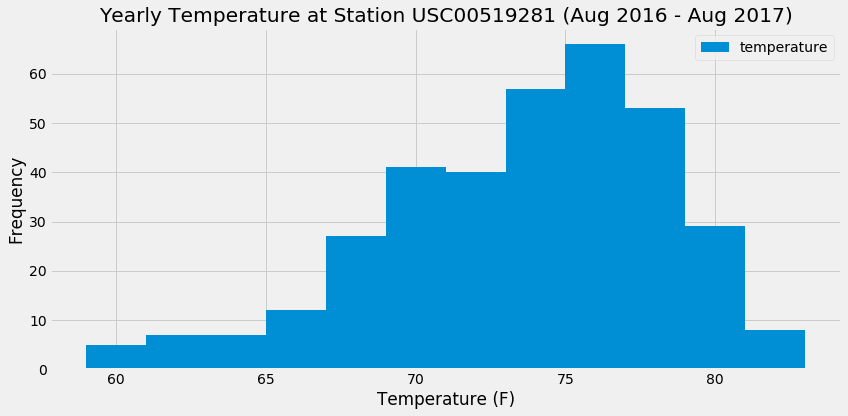

In [102]:
# Plot the results
fig, ax=plt.subplots(figsize = (12,6))

station_USC00519281_temp_df.plot.hist(bins=12, ax=ax)

# Title & Lables
ax.set_xlabel('Temperature (F)')
ax.set_ylabel('Frequency')
ax.set_title('Yearly Temperature at Station USC00519281 (Aug 2016 - Aug 2017)')

# Save Figure
plt.savefig("Images/USC00519281_temperature_histogram.png")

# plot
plt.tight_layout()
plt.show()


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
